In [1]:
import warnings
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import pandas_gbq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('seaborn-dark')
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
%reload_ext google.cloud.bigquery

In [2]:
sql = """
WITH customer_orders AS (
    SELECT 
        global_entity_id                                                                           AS global_entity_id,                 
        region                                                                                     AS region,
        country_name                                                                               AS country,
        warehouse.city                                                                             AS city,
        warehouse.warehouse_id                                                                     AS warehouse_id,
        warehouse.warehouse_name                                                                   AS warehouse_name,
        warehouse.store_name                                                                       AS store_name,
        order_id                                                                                   AS order_id,
        analytical_customer_id                                                                     AS customer_id,
        DATE(order_placed_localtime_at)                                                            AS order_date,
        order_value_euro.amt_gmv_eur                                                               AS gmv_eur,
        delivery_time_minutes                                                                      AS delivery_time_minutes
    FROM `fulfillment-dwh-production.cl_dmart.customer_orders` 
    -- Date filters
    WHERE DATE(order_placed_localtime_at) <= CURRENT_DATE()
    AND DATE(order_placed_localtime_at) >  DATE_SUB(CURRENT_DATE, INTERVAL 2 MONTH)                --- 2 months ago till this month
    AND DATE(order_placed_localtime_at) <= CURRENT_DATE()
    -- Filters
    AND is_dmart
    AND is_sent
    AND is_failed = FALSE 
    AND is_cancelled = FALSE),

customer_orders_agg AS (
	SELECT 
	    FORMAT_DATE('%Y%m',DATE_TRUNC(co.order_date, MONTH))                                        AS order_month,
	    -- Categorical Variables
	    co.global_entity_id                                                                         AS global_entity_id,
	    co.country                                                                                  AS country,
	    --co.city                                                                                   AS city,
	    -- Aggregation
	    COUNT(co.order_id)                                                                          AS number_of_orders,
	    COUNT(DISTINCT co.customer_id)                                                              AS number_of_unique_customers,
	    ROUND(SUM(co.gmv_eur),2)                                                                    AS gmv_eur,
	    ROUND(SUM(co.gmv_eur)/COUNT(co.order_id),2)                                                 AS gmv_eur_per_order,
	    ROUND(AVG(co.delivery_time_minutes),2)                                                      AS avg_delivery_time_mins
	FROM customer_orders AS co
	GROUP BY 1,2,3
	ORDER BY 1 DESC, 6 DESC, 7 DESC    -- Month DESC, customers DESC, GMV DESC
)

SELECT 
*, 
ROUND(SAFE_DIVIDE(gmv_eur, SUM(gmv_eur) OVER(PARTITION BY order_month)) * 100,2)                  AS gmv_perc_contribution_to_DH
FROM customer_orders_agg as coagg
ORDER BY 1 DESC, 6 DESC, 7 DESC
"""
df = pandas_gbq.read_gbq(sql, project_id = "dh-darkstores-live")

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 290.51rows/s]


In [3]:
df.head()

,order_month,global_entity_id,country,number_of_orders,number_of_unique_customers,gmv_eur,gmv_eur_per_order,avg_delivery_time_mins,gmv_perc_contribution_to_DH
0,202109,YS_TR,Turkey,1691305,807674,9494460.470000000,5.610000000,14.440000000,17.080000000
1,202109,HS_SA,Saudi Arabia,286114,162965,5822522.100000000,20.350000000,23.760000000,10.470000000
2,202109,FP_SG,Singapore,257612,121207,5422544.920000000,21.050000000,22.160000000,9.760000000
3,202109,TB_AE,United Arab Emirates,316867,135685,4711317.590000000,14.870000000,22.050000000,8.480000000
4,202109,TB_KW,Kuwait,189874,92427,3833125.400000000,20.190000000,31.270000000,6.900000000


In [20]:

# September 2021 data
data_202109 = df[df['order_month'] == '202109']

# Sort values by gmv_eur in descending order
data_202109.sort_values(by=['gmv_eur'], ascending = False).reset_index(drop = True)
data_202109.head()

,order_month,global_entity_id,country,number_of_orders,number_of_unique_customers,gmv_eur,gmv_eur_per_order,avg_delivery_time_mins,gmv_perc_contribution_to_DH
0,202109,YS_TR,Turkey,1627965,790999,9147604.510000000,5.620000000,14.510000000,17.200000000
1,202109,HS_SA,Saudi Arabia,272847,157182,5575379.350000000,20.430000000,23.680000000,10.480000000
2,202109,FP_SG,Singapore,245470,118148,5149092.940000000,20.980000000,22.120000000,9.680000000
3,202109,TB_AE,United Arab Emirates,302881,132038,4500653.700000000,14.860000000,22.040000000,8.460000000
4,202109,TB_KW,Kuwait,181615,90120,3654512.220000000,20.120000000,31.110000000,6.870000000


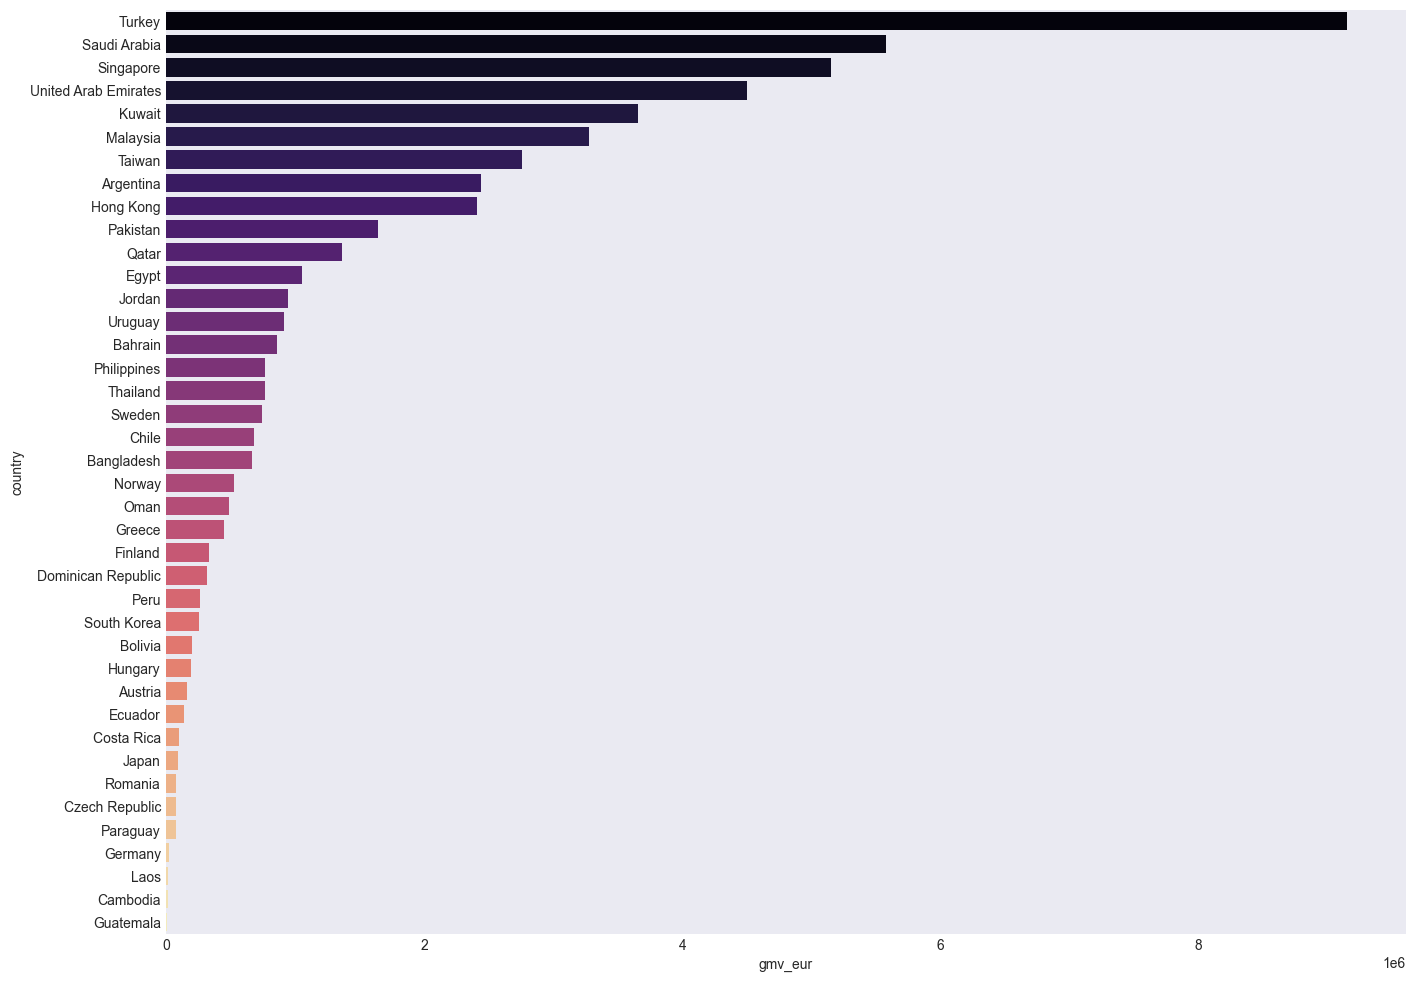

In [21]:
plt.figure(figsize=(16,12))
sns.barplot(y='country',x='gmv_eur', data=data_202109, palette='magma');